In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from qutip import Qobj, sesolve
import sympy as sp
import os

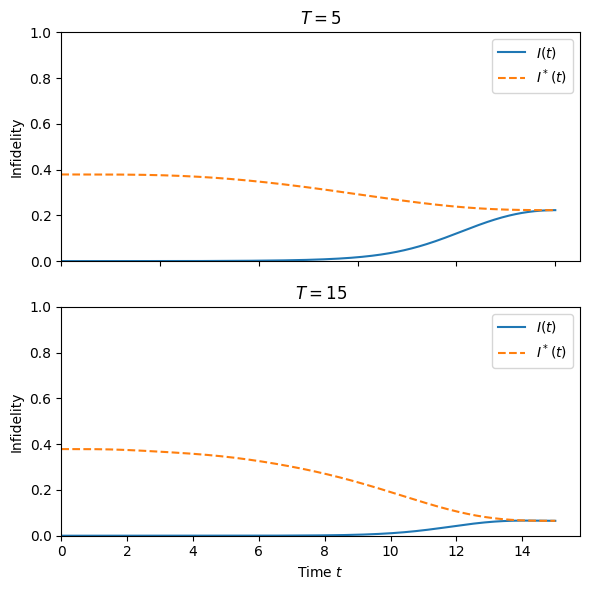

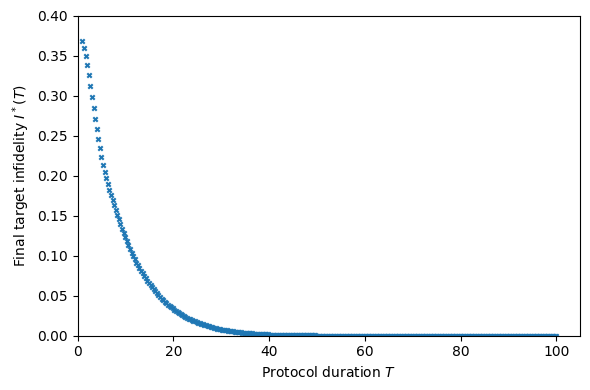

In [ ]:
#####################
# Define Variables and Relevant Functions
#####################

J = 1 # satisfies initial condition h(0)/J = 1
# T_vals = np.linspace(10.9999999975, 11.0000000025, 1000)
T_vals = np.linspace(1, 100, 300)
T_plot = [5, 15]
# T_vals = [10, 11]
N_t_plot = 400
N_t_scan = 80
I_star_final = np.zeros(len(T_vals))

def control(t, T):
    """Transverse field h(t) = cos^2(pi * t/(2 * T))"""
    return np.cos((np.pi * t) / (2 * T))**2

def hamiltonian(t, T, J):
    """4x4 Hamiltonian matrix in the basis [uu, dd, ud, du]
        We are taking hbar = 1 for simplicity"""
    h = control(t, T)
    a, b, c = J/4, -J/4, h/2
    return np.array([
        [a, 0, c, c],
        [0, a, c, c],
        [c, c, b, 0],
        [c, c, 0, b]
    ], dtype=complex)

def schrodinger_rhs(t, y, J, T):
    """This function computes the right hand side of the Schroedinger equation when written as d(psi)/dt = -i/hbar * H @ psi.
            This will be useful later when solving the Schroedinger equation to time-evolve states using the solve_ivp method.
            Again let's take hbar = 1 for simplicity"""
    H = hamiltonian(t, T, J)
    # rhs = np.matmul(H, y)
    # return -1j * rhs
    return -1j * (H @ y)

def qt_hamiltonian(t, args):
    """Define the Hamiltonian using the qutip library.
        This will be useful to solve the Schroedinger equation later (using QuTip instead of solve_ivp)"""
    J = args['J']
    T = args['T']
    H_np = hamiltonian(t, T, J)
    return Qobj(H_np)

#####################
# Pipeline to Find Infidelities
#####################

# for k, T in enumerate(T_vals):
def compute_infidelities(T, N_t):
    t_vals = np.linspace(0, T, N_t)

    # region
    #####################
    # Diagonalise Hamiltonian to Find Instantaneous Ground States
    #####################

    # storage: eigenvalues [N_t, 4], eigenvectors [N_t, 4, 4]
    e_vals = np.zeros((N_t, 4), dtype=float)
    e_vecs = np.zeros((N_t, 4, 4), dtype=complex)

    for i, t in enumerate(t_vals):
        H_t = hamiltonian(t, T, J)
        values, vectors = np.linalg.eigh(H_t)   # values sorted ascending
        e_vals[i, :] = values
        e_vecs[i, :, :] = vectors             # columns are eigenvectors

    ground_energies = e_vals[:, 0]        # shape (N_t,)
    ground_states  = e_vecs[:, :, 0]      # shape (N_t, 4)

    psi_star = np.array([0, 0, 1/np.sqrt(2), 1/np.sqrt(2)], dtype=complex)
    psi_init = ground_states[0]
    # endregion

    #region
    #####################
    # Solve Time-Dependent Schroedinger Eqn
    #####################

    psi0 = Qobj(psi_init)  # initial condition as Qobj ket
    args = {'J': J, 'T': T}

    result = sesolve(qt_hamiltonian, psi0, t_vals, e_ops=[], args=args)
    psi_t_list = result.states                     # list of length N_t
    psi_t = np.vstack([psi.full().ravel() for psi in psi_t_list])  # (N_t, 4)

    # endregion

    #region
    #####################
    # Calculate Infidelities
    #####################

    I  = np.zeros(N_t)
    I_star = np.zeros(N_t)

    for i in range(N_t):
        I[i]      = 1 - np.abs(np.vdot(ground_states[i], psi_t[i]))**2
        I_star[i] = 1 - np.abs(np.vdot(psi_star, psi_t[i]))**2
    I[-1] = 1 - np.abs(np.vdot(psi_star, psi_t[i]))**2
    # endregion

    return t_vals, I, I_star, I_star[-1], I[-1]

outdir = r"C:\Users\cassi\Documents\Cambridge\III\Project\Baptista\IMPRS-QDC Project\figures\part-a"
os.makedirs(outdir, exist_ok=True)

# ---------------------
# Figure 1: 2×1 subplots for T=5 and T=15
# ---------------------
fig1, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=False)

for ax, T in zip(axes, T_plot):
    t_vals, I, I_star, _, _ = compute_infidelities(T, N_t_plot)
    ax.plot(t_vals, I, label=r"$I(t)$")
    ax.plot(t_vals, I_star, linestyle="--", label=r"$I^*(t)$")
    ax.set_title(fr"$T={T:g}$")
    ax.set_xlabel(r"Time $t$")
    ax.set_ylabel("Infidelity")
    ax.set_ylim(0, 1)
    ax.set_xlim(0,)
    ax.legend()

fig1.tight_layout()
fig1.savefig(os.path.join(outdir, "infidelities_T5_T15_subplots.pdf"),
              format="pdf", bbox_inches="tight")


# ---------------------
# Figure 2: Final I*(T) vs T
# ---------------------
I_star_final = np.zeros(len(T_vals), dtype=float)
for k, T in enumerate(T_vals):
    _, _, _, I_star_T, _ = compute_infidelities(float(T), N_t_scan)
    I_star_final[k] = I_star_T

fig2 = plt.figure(figsize=(6, 4))
plt.scatter(T_vals, I_star_final, s=10, marker="x")
plt.xlabel(r"Protocol duration $T$")
plt.ylabel(r"Final target infidelity $I^*(T)$")
plt.ylim(0, min(1.0, max(0.4, float(np.nanmax(I_star_final)) * 1.05)))
plt.xlim(0,)
plt.tight_layout()
fig2.savefig(os.path.join(outdir, "Istar_vs_T.pdf"),
             format="pdf", bbox_inches="tight")

plt.show()

# region
# # store final target infidelity for this T
# I_star_final[k] = I_star[-1]

# plt.figure(figsize=(5, 3))
# plt.plot(t_vals, I, color='orange', marker='x', markersize=3, linestyle='-', label='$I(t)$')
# plt.plot(t_vals, I_star, color='blue', marker='o', markersize=3, linestyle='--', label='$I^*(t)$')
# plt.title(fr'$I(t)$ and $I^*(t)$ for $T={T}$')
# plt.xlabel("Time $t$")
# plt.ylim(0,1)
# plt.legend()
# plt.tight_layout()
# plt.show()    
# endregion

# region
# #####################
# # Identifying Adiabatic Regime
# #####################

# # Define adiabatic regime
# threshold = 0.05

# mask = I_star_final < threshold

# if np.any(mask):
#     first_idx = np.where(mask)[0][0]
#     T_adiabatic = T_vals[first_idx]
#     print("First T with I*(T) <", threshold, "is:", T_adiabatic)

# plt.figure()
# plt.scatter(T_vals, I_star_final, marker='x', s=2)
# # plt.axhline(threshold, color='r', linestyle='--')
# plt.xlim(0,)
# plt.ylim(top=0.4)
# plt.xlabel("T")
# plt.ylabel(r"$I^*(T)$")
# plt.tight_layout()
# plt.show()
# endregion
